<b>CS225 - Project 3</b>
<br/>
U-ASK is a unified indexing and query processing for kNN spatial-keyword queries supporting negative keyword predicates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from geopy.distance import geodesic
import copy
import time

In [2]:
class Point:
    def __init__(self, id, x, y, keywords):
        self.id = id
        self.x = x
        self.y = y
        self.keywords = keywords


In [3]:
class QuadTreeNode:
    def __init__(self, x0, y0, x1, y1, capacity=4, max_depth=10, depth=0):
        self.bounds = (x0, y0, x1, y1)
        self.capacity = capacity
        self.points = []
        self.divided = False
        self.children = []
        self.max_depth = max_depth
        self.depth = depth

    def insert(self, point):
        stack = [(self, point)]  # Stack of (node, point) pairs
        while stack:
            node, current_point = stack.pop()
            if not node.in_bounds(current_point):
                continue

            if len(node.points) < node.capacity or node.depth >= node.max_depth:
                node.points.append(current_point)
                continue

            if not node.divided:
                node.subdivide()

            for child in node.children:
                stack.append((child, current_point))

    def subdivide(self):
        x0, y0, x1, y1 = self.bounds
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2

        self.children = [
            QuadTreeNode(x0, y0, mid_x, mid_y, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(mid_x, y0, x1, mid_y, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(x0, mid_y, mid_x, y1, self.capacity, self.max_depth, self.depth + 1),
            QuadTreeNode(mid_x, mid_y, x1, y1, self.capacity, self.max_depth, self.depth + 1),
        ]
        self.divided = True




    def in_bounds(self, point):
        x0, y0, x1, y1 = self.bounds
        return x0 <= point.x <= x1 and y0 <= point.y <= y1

    def query_range(self, x0, y0, x1, y1):
        points_in_range = []
        if not self.intersects(x0, y0, x1, y1):
            return points_in_range

        for point in self.points:
            if x0 <= point.x <= x1 and y0 <= point.y <= y1:
                points_in_range.append(point)

        if self.divided:
            for child in self.children:
                points_in_range.extend(child.query_range(x0, y0, x1, y1))

        return points_in_range

    def intersects(self, x0, y0, x1, y1):
        qx0, qy0, qx1, qy1 = self.bounds
        return not (x1 < qx0 or x0 > qx1 or y1 < qy0 or y0 > qy1)


In [4]:
class InvertedIndex:
    def __init__(self):
        self.index = {}

    def insert(self, point):
        for keyword in point.keywords:
            if keyword not in self.index:
                self.index[keyword] = set()
            self.index[keyword].add(point.id)

    def filter(self, keywords, negative_keywords):
        candidates = set()
        for keyword in keywords:
            if keyword in self.index:
                candidates.update(self.index[keyword])
        for neg_keyword in negative_keywords:
            if neg_keyword in self.index:
                candidates.difference_update(self.index[neg_keyword])
        return candidates


In [5]:
#POWER Algorithm (TKQN)**

def POWER(quadtree, inverted_index, query_coords, keywords, negative_keywords, k):
    # Spatial filtering (kNN using quadtree)
    x, y = query_coords
    radius = 0.1  # Initial search radius (adjust as needed)
    while True:
        spatial_candidates = quadtree.query_range(x - radius, y - radius, x + radius, y + radius)
        if len(spatial_candidates) >= k:
            break
        radius *= 2  # Expand search radius

    #Keyword filtering
    keyword_candidates = inverted_index.filter(keywords, negative_keywords)

    #Intersection and ranking
    final_candidates = [point for point in spatial_candidates if point.id in keyword_candidates]
    final_candidates.sort(key=lambda p: (p.x - x) ** 2 + (p.y - y) ** 2)  # Sort by distance

    # Return top-k results
    return final_candidates[:k]


In [6]:


def parse_line(line): 
    parts = line.strip().split()
    
    # Extract data
    object_id = int(parts[0])
    latitude = float(parts[1])
    longitude = float(parts[2])
    num_keywords = int(parts[3])
    
    keywords = []
    for i in range(num_keywords):
        keyword = parts[4 + i * 2]
        # weight = float(parts[5 + i * 2])
        keywords.append(keyword)

    return {
        "id": object_id,
        "x": latitude,
        "y": longitude,
        "keywords": keywords
    }

def parse_files(folder_path):
    data_points = []
    # Use glob to match all txt files
    file_list = glob.glob(os.path.join(folder_path, '*.txt'))
    
    for file_path in file_list:
        with open(file_path, 'r') as file:
            for line in file:
                # Parse each line and append to the data_points list
                data_point = parse_line(line)
                data_points.append(data_point)

    return data_points

folder_path = 'data' 
data_points = parse_files(folder_path)


#print(data_points[:5])
print(f"Total number of data points: {len(data_points)}")

Total number of data points: 10000000


In [7]:
# import sys
# print(sys.executable)
#!pip3.9 install geopy

In [8]:

def group_queries_by_proximity(q, radius_miles=100):
    groups = []
    queries = copy.deepcopy(q)
    while queries:
        first_query = queries.pop(0)
        current_group = [first_query]
        current_group_coords = first_query[0]

        for other_query in queries[:]:
            other_query_coords = other_query[0]
            distance = geodesic(current_group_coords, other_query_coords).miles
            if distance <= radius_miles:
                current_group.append(other_query)
                queries.remove(other_query)

        groups.append(current_group)
    return groups


In [9]:
x_min, y_min = -180, -90  # Minimum longitude and latitude
x_max, y_max = 180, 90    # Maximum longitude and latitude

# Initialize the quadtree
quadtree = QuadTreeNode(x_min, y_min, x_max, y_max, capacity=4, max_depth=15,depth=0)

# Insert points
# for point in data_points:
#     point_obj = Point(point["id"], point["x"], point["y"], point["keywords"])
#     quadtree.insert(point_obj)

# Initialize the inverted index
inverted_index = InvertedIndex()




for point in data_points:
    # Create a Point object
    point_obj = Point(point["id"], point["x"], point["y"], point["keywords"])
    # Insert into the quadtree
    quadtree.insert(point_obj)
    # Insert into the inverted index
    inverted_index.insert(point_obj)


print("Quadtree and Inverted Index initialized successfully!")


Quadtree and Inverted Index initialized successfully!


In [10]:
from collections import defaultdict
#The function uses an expanding search radius to ensure that each query has at least k spatial candidates. 
def generate_spatial_candidates(quadtree, queries, k):
    query_radii = {}
    spatial_candidates = defaultdict(set)
    
    # Start with initial search radius
    initial_radius = 0.1  # adjust based on context
    for i, (query_coords, _, _) in enumerate(queries):
        x, y = query_coords
        radius = initial_radius
        while True:
            curr_candidates = set(quadtree.query_range(x - radius, y - radius, x + radius, y + radius))
            spatial_candidates[i].update(curr_candidates)
            if len(spatial_candidates[i]) >= k:
                query_radii[i] = radius
                break
            radius *= 2
    
    return spatial_candidates, query_radii
#performs an intersection between the spatial candidates and the keyword-based candidates
def filter_candidates_by_keywords(spatial_candidates, queries, inverted_index):
    final_candidates = {}
    
    for i, (_, keywords, negative_keywords) in enumerate(queries):
        keyword_candidates = inverted_index.filter(keywords, negative_keywords)
        # Intersect with spatial candidates
        intersected = [point for point in spatial_candidates[i] if point.id in keyword_candidates]
        final_candidates[i] = intersected
    
    return final_candidates

def process_queries_optimized(quadtree, inverted_index, queries, k):
    # Get spatial candidates for each query
    spatial_candidates, _ = generate_spatial_candidates(quadtree, queries, k)

    # Filter based on keywords
    all_candidates = filter_candidates_by_keywords(spatial_candidates, queries, inverted_index)

    # Sort by distance and retrieve top-k for each query
    results = {}
    for i, (query_coords, _, _) in enumerate(queries):
        x, y = query_coords
        sorted_by_distance = sorted(all_candidates[i], key=lambda p: (p.x - x) ** 2 + (p.y - y) ** 2)
        results[i] = sorted_by_distance[:k]
    
    return results

In [11]:

queries =[ ((40.7128, -74.006), ['barbecue', 'cheese'], ['salty']),
((34.0522, -118.2437), ['pizza', 'salad'], ['sour']),
((41.8781, -87.6298), ['pizza', 'seafood'], ['bitter']),
((29.7604, -95.3698), ['barbecue', 'burger'], ['cheap']),
((33.4484, -112.074), ['burger', 'burger'], ['greasy']),
((39.7392, -104.9903), ['cheese', 'cheesecake'], ['salty']),
((29.4241, -98.4936), ['barbecue', 'salad'], ['greasy']),
((32.7157, -117.1611), ['sandwich', 'salad'], ['sweet']),
((32.7767, -96.797), ['barbecue', 'coffee'], ['expensive']),
((37.7749, -122.4194), ['wine', 'coffee'], ['sour']),
((40.4406, -79.9959), ['burger', 'chocolate'], ['expensive']),
((39.9526, -75.1652), ['pasta', 'salad'], ['mild']),
((47.6062, -122.3321), ['coffee', 'barbecue'], ['tough']),
((25.7617, -80.1918), ['burger', 'pasta'], ['expensive']),
((38.9072, -77.0369), ['cheesecake', 'coffee'], ['mild']),
((45.5051, -122.675), ['coffee', 'burger'], ['mild']),
((35.2271, -80.8431), ['cheese', 'chocolate'], ['spicy']),
((39.7684, -86.1581), ['chocolate', 'pasta'], ['sour']),
((36.1627, -86.7816), ['wine', 'taco'], ['mild']),
((42.3601, -71.0589), ['cheesecake', 'steak'], ['expensive']),
((36.1699, -115.1398), ['chocolate', 'sushi'], ['spicy']),
((27.9506, -82.4572), ['pizza', 'burger'], ['salty']),
((35.0844, -106.6504), ['burger', 'salad'], ['sweet']),
((43.0389, -87.9065), ['burger', 'vegan'], ['expensive']),
((44.9778, -93.265), ['steak', 'salad'], ['salty']),
((37.3382, -121.8863), ['pasta', 'seafood'], ['sweet']),
((35.7796, -78.6382), ['sushi', 'salad'], ['sweet']),
((38.2527, -85.7585), ['salad', 'wine'], ['greasy']),
((36.7468, -119.7726), ['coffee', 'wine'], ['greasy']),
((36.8529, -75.978), ['burger', 'cheese'], ['cheap']),
((41.2565, -95.9345), ['salad', 'wine'], ['spicy']),
((47.6062, -122.3321), ['coffee', 'barbecue'], ['sour']),
((33.748, -84.388), ['barbecue', 'wine'], ['cheap']),
((30.2672, -97.7431), ['steak', 'pasta'], ['salty']),
((41.4993, -81.6944), ['cheesecake', 'pizza'], ['sour']),
((39.1031, -84.512), ['burger', 'sandwich'], ['sour']),
((44.468, -73.1944), ['wine', 'barbecue'], ['cheap']),
((36.1575, -115.1492), ['chocolate', 'pizza'], ['spicy']),
((42.6526, -73.7562), ['wine', 'burger'], ['expensive']),
((43.615, -116.2023), ['steak', 'burger'], ['cheap']),
((46.8772, -96.7898), ['barbecue', 'wine'], ['sweet']),
((42.2808, -83.743), ['sandwich', 'pizza'], ['sour']),
((33.5207, -86.8025), ['wine', 'chocolate'], ['sweet']),
((32.0809, -81.0912), ['chocolate', 'salad'], ['spicy']),
((25.7907, -80.13), ['salad', 'pasta'], ['sweet']),
((33.749, -84.388), ['steak', 'taco'], ['salty']),
((35.228, -80.8349), ['barbecue', 'seafood'], ['cheap']),
((44.9393, -92.2674), ['salad', 'coffee'], ['sweet']),
((42.8713, -85.6861), ['sushi', 'seafood'], ['cheap']),
((28.5383, -81.3792), ['salad', 'steak'], ['mild']),
((40.7608, -111.891), ['sandwich', 'cheesecake'], ['cheap']),
((31.9519, -110.9709), ['steak', 'coffee'], ['expensive']),
((40.7178, -74.0431), ['burger', 'vegan'], ['bitter']),
((40.7357, -74.1724), ['barbecue', 'taco'], ['cheap']),
((40.9312, -73.8988), ['wine', 'sandwich'], ['cheap']),
((34.1478, -118.1445), ['pasta', 'cheese'], ['expensive']),
((33.7701, -118.1937), ['coffee', 'taco'], ['cheap']),
((34.0259, -118.4965), ['burger', 'pizza'], ['sweet']),
((42.0451, -87.6877), ['steak', 'cheesecake'], ['sweet']),
((41.7508, -88.1535), ['pizza', 'cheesecake'], ['sweet']),
((41.525, -88.0817), ['chocolate', 'vegan'], ['greasy'])
]

print (f" Number of queries : {len(queries)} queries \n")
groups_20 = group_queries_by_proximity(queries, 20)
print (f" Number of groups : {len(groups_20)} groups \n")
i=1
for group in groups_20:
    print(f" Group {i} : {group} \n")
    i+=1
    


 Number of queries : 61 queries 

 Number of groups : 48 groups 

 Group 1 : [((40.7128, -74.006), ['barbecue', 'cheese'], ['salty']), ((40.7178, -74.0431), ['burger', 'vegan'], ['bitter']), ((40.7357, -74.1724), ['barbecue', 'taco'], ['cheap']), ((40.9312, -73.8988), ['wine', 'sandwich'], ['cheap'])] 

 Group 2 : [((34.0522, -118.2437), ['pizza', 'salad'], ['sour']), ((34.1478, -118.1445), ['pasta', 'cheese'], ['expensive']), ((33.7701, -118.1937), ['coffee', 'taco'], ['cheap']), ((34.0259, -118.4965), ['burger', 'pizza'], ['sweet'])] 

 Group 3 : [((41.8781, -87.6298), ['pizza', 'seafood'], ['bitter']), ((42.0451, -87.6877), ['steak', 'cheesecake'], ['sweet'])] 

 Group 4 : [((29.7604, -95.3698), ['barbecue', 'burger'], ['cheap'])] 

 Group 5 : [((33.4484, -112.074), ['burger', 'burger'], ['greasy'])] 

 Group 6 : [((39.7392, -104.9903), ['cheese', 'cheesecake'], ['salty'])] 

 Group 7 : [((29.4241, -98.4936), ['barbecue', 'salad'], ['greasy'])] 

 Group 8 : [((32.7157, -117.1611), [

In [12]:
print("********************************** Original Power *************************************************")
#Original POWER (one-at-a-time)
start_time = time.time()
for query in queries:
    res= POWER(quadtree, inverted_index, *query, k=5)
    #print("Query Results:", res)
    print("Query Results:", [point.id for point in res])
original_latency = time.time() - start_time
print(f"Original POWER Latency: {original_latency:.4f} seconds")





********************************** Original Power *************************************************
Query Results: [4890007, 7235328, 9936798, 8379975, 8379996]
Query Results: [6325803, 6483835, 4719831, 4552016, 7494328]
Query Results: [6069740, 6007754, 3703093, 7162080, 7752876]
Query Results: [9556624]
Query Results: []
Query Results: [4535847, 9765868, 3695205, 6229526, 7782154]
Query Results: [843606, 9556624, 838787, 6325803, 1466174]
Query Results: [6325803, 4719831, 843606, 8214899, 5456495]
Query Results: [9556624, 8476702, 5189391, 4948385, 7393883]
Query Results: [1198963, 308442, 5069662, 6260135, 4978224]
Query Results: [9481997, 4672222, 5020212, 8893405, 9779798]
Query Results: [4066916, 6011025, 4512254, 7081660, 4714871]
Query Results: [8476702, 9417377, 9856863, 1107466, 3275442]
Query Results: []
Query Results: [5905669, 7300789, 8435207, 8698632]
Query Results: []
Query Results: [4796880, 3182446, 6947911, 5808596, 5168952]
Query Results: [8571124, 7023946, 7024658

In [13]:
print("********************************** Batched Power (Radius 20 miles)**********************************")


start_time = time.time()
for group in groups_20:
    results = process_queries_optimized(quadtree, inverted_index, group, k=5)

    for i, result in results.items():
        print("Query Results:", [point.id for point in result])
batched_latency = time.time() - start_time
print(f"Batched POWER Latency: {batched_latency:.4f} seconds")

********************************** Batched Power (Radius 20 miles)**********************************
Query Results: [4890007, 7235328, 9936798, 8379975, 8379996]
Query Results: [1152919, 2045047, 6186521, 8226033, 3449701]
Query Results: [2329829, 8317113, 9615359, 328125, 1977188]
Query Results: [3588555, 9653162, 5396026, 5436586, 7267785]
Query Results: [6325803, 6483835, 4719831, 4552016, 7494328]
Query Results: [21631, 5299264, 3511446, 8652333, 2147388]
Query Results: [3977892, 6417679, 6375517, 8983656, 9872181]
Query Results: [6483835, 4552016, 7494328, 9488645, 2748281]
Query Results: [6069740, 6007754, 3703093, 7162080, 7752876]
Query Results: [1362654, 9688294, 4507470, 177471, 1933507]
Query Results: [9556624]
Query Results: []
Query Results: [4535847, 9765868, 3695205, 6229526, 7782154]
Query Results: [843606, 9556624, 838787, 6325803, 1466174]
Query Results: [6325803, 4719831, 843606, 8214899, 5456495]
Query Results: [9556624, 8476702, 5189391, 4948385, 7393883]
Query Res

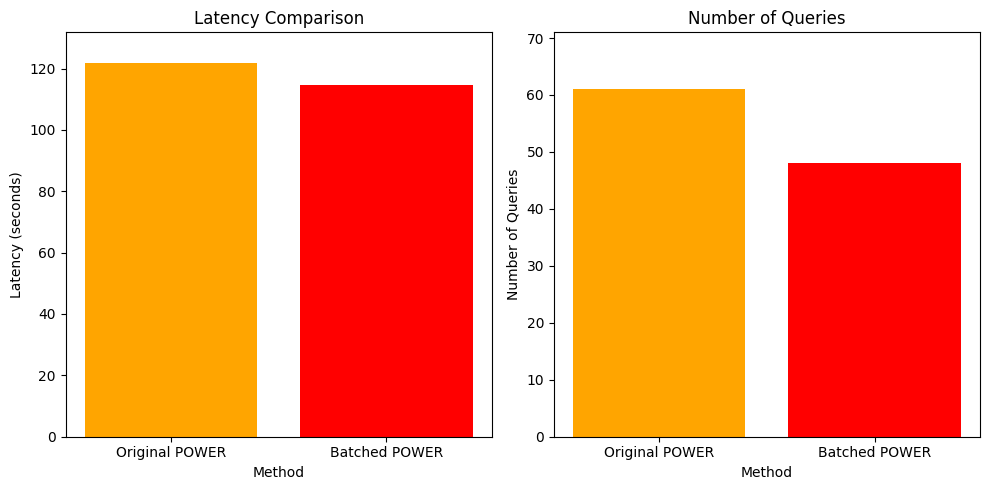

In [16]:

# Latency data
latencies = [original_latency, batched_latency]
methods = ['Original POWER', 'Batched POWER']

# Number of queries data
num_queries = [len(queries), len(groups_20)]

# Plotting latency comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for latency
plt.bar(methods, latencies, color=['orange', 'red'])
plt.title('Latency Comparison')
plt.xlabel('Method')
plt.ylabel('Latency (seconds)')
plt.ylim(0, max(latencies) + 10)

# Plotting number of queries comparison
plt.subplot(1, 2, 2)  # Create a subplot for number of queries
plt.bar(methods, num_queries, color=['orange', 'red'])
plt.title('Number of Queries')
plt.xlabel('Method')
plt.ylabel('Number of Queries')
plt.ylim(0, max(num_queries) + 10)

# Show the plots
plt.tight_layout()  # Adjust subplot params so they fit in the figure
plt.show()